# 2019 POLEVAL TASK 6.2
**Fit ML models**


---





http://2019.poleval.pl/index.php/tasks/task6


## To install and download

In [1]:
from IPython.display import clear_output
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import re
import numpy as np
import string
import time

# sklearn - modele do ML
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
import seaborn as sns
# model
import tensorflow as tf
import keras
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

# ewaluacja
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')

In [2]:
#Authenticate
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
path1 = '/content/drive/MyDrive/POLEVAL_6.2/train_data_preprocessed.csv' 
path2 = '/content/drive/MyDrive/POLEVAL_6.2/test_data_preprocessed.csv'  

train_data = pd.read_csv(path1, delimiter = ",")
test_data = pd.read_csv(path2, delimiter = ",")
train_data = train_data.drop(["Unnamed: 0"], axis = 1)
test_data = test_data.drop(["Unnamed: 0"], axis = 1)

test_data.head()

,tweets_txt,tag,tag_val,clean_tokenized,cleaned_text,lemmatized
0,"@anonymized_account spoko, jak im duda z moraw...",0,Neutral,"['spoko', 'duda', 'morawieckim', 'zamówią', 'p...",spoko duda morawieckim zamówią pięć piw,spoko duda morawieckim zamówić pięć piwo
1,@anonymized_account @anonymized_account ale on...,0,Neutral,"['szans', 'zagrania', 'proba', 'czysta', 'prow...",szans zagrania proba czysta prowizorka,szansa zagranie proba czysty prowizorka
2,@anonymized_account no czy prezes nie miał rac...,0,Neutral,"['prezes', 'racji', 'mówiącze', 'zdradzieckie'...",prezes racji mówiącze zdradzieckie mordy racji,prezes racja mówiącze zdradziecki morda racja
3,@anonymized_account @anonymized_account przeci...,0,Neutral,['przewrotka'],przewrotka,przewrotka
4,@anonymized_account @anonymized_account owszem...,0,Neutral,"['podatki', 'okolicznościach', 'małysza', 'odp...",podatki okolicznościach małysza odpalili teamu...,podatek okoliczność małysza odpalić team orlen


In [4]:
X_train = train_data['lemmatized'].astype('U') 
y_train = train_data['tag'].astype('U') 

X_test = test_data['lemmatized'].astype('U')
y_test = test_data['tag'].astype('U')

## Vectorize data

In [5]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=10041)
vectors = vectorizer.fit_transform(X_train, X_test)

In [6]:
X_train_vec = vectorizer.transform(X_train)
X_test_vec  = vectorizer.transform(X_test)

## Define model evaluation function
Perl script calculates Precision, Recall, Balanced F-score and Accuracy, however separate function model_Evalute was defined. PERL script was inconvient to run in Python

In [ ]:
import subprocess, os
model_eval = subprocess.Popen(["perl", "/content/drive/MyDrive/evaluate1.pl"], stdout=subprocess.PIPE)

In [12]:
def model_Evaluate(model):
  # Predykcja danych na danych testowych
  y_pred = model.predict(X_test_vec)

  # Wyświetlenie metryk ewaluacji na podstawie predykcji i ground truth (faktycznych etykiet)
  print(classification_report(y_test, y_pred))

  # Obliczamy i wyświetlamy confusion matrix
  cf_matrix = confusion_matrix(y_test, y_pred)
  categories = ['Neutral', 'Cyberbullying', 'Hate-Speech']
  group_names = ['True Neut','False CB', 'False HS', 'False Neut','True CB', 'False HS', 'False Neut', 'False CB', 'True HS' ]
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
  labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names, group_percentages)]
  labels = np.asarray(labels).reshape(3,3)
  sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
  xticklabels = categories, yticklabels = categories)
  plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
  plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
  plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

## Model 1 - Logistic Regression

              precision    recall  f1-score   support

           0       0.87      1.00      0.93       866
           1       0.00      0.00      0.00       134
           2       0.00      0.00      0.00         0

    accuracy                           0.87      1000
   macro avg       0.29      0.33      0.31      1000
weighted avg       0.75      0.87      0.80      1000



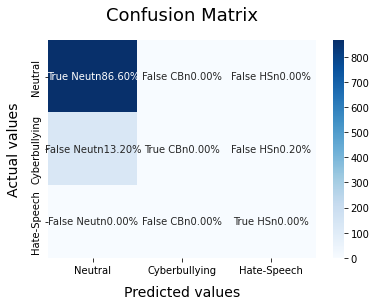

In [19]:
# fit model
clf = OneVsRestClassifier(LogisticRegression())
clf.fit(X_train_vec, y_train)
y_pred1 = clf.predict(X_test_vec)
model_Evaluate(clf)


In [26]:
train_data.groupby('tag_val').nunique()

,tweets_txt,tag,clean_tokenized,cleaned_text,lemmatized
tag_val,,,,,
Cyberbullying,253,1,246,246,246
Hate-speech,597,1,521,521,521
Neutral,9177,1,8704,8703,8682


In [27]:
test_data.groupby('tag_val').nunique()  ### z jakiegoś powodu nie ma hate speeech w test data - dlatego mdoel wychodzi zjebany. Trzeba tu podzielić train_test splitem raczej

,tweets_txt,tag,clean_tokenized,cleaned_text,lemmatized
tag_val,,,,,
Cyberbullying,134,1,123,123,123
Neutral,866,1,836,835,835


In [29]:
# roc curve for classes -- wywala błąd bo oczekuje 3 kategorii a w y_test są tylko 2
fpr = {}
tpr = {}
thresh ={}

n_class = 3
#y_test2 = y_test + 1

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_pred1[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class Neg vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class Neut vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class Pos vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);    

IndexError: ignored